In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import sys

mod_path = '/Users/bohua/Documents/Equota/energyanalytics/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)

In [3]:
from bayesian_cp_detect import bayesian_cp_3 as bcp
import datetime

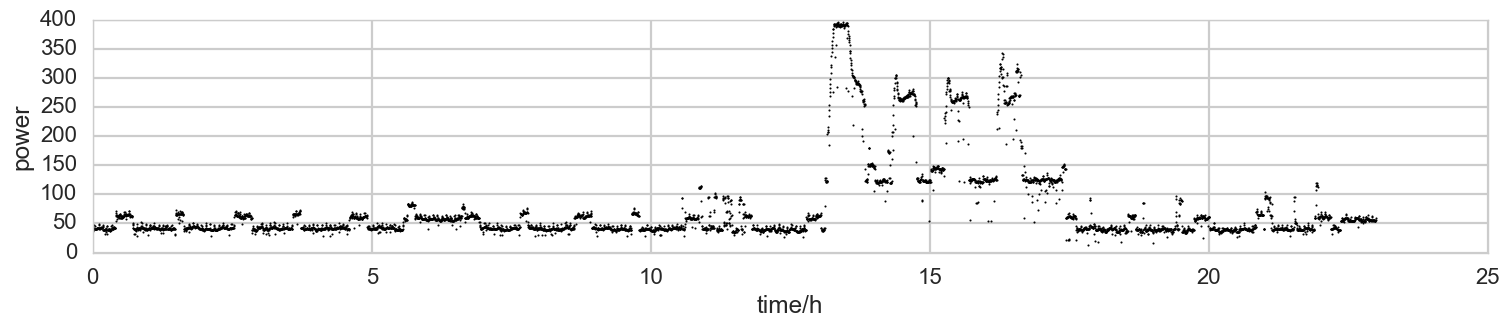

In [4]:
# example of read_dat_0819

t, dat, t_utc = bcp.read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

plt.figure(figsize=[18,3])
plt.plot(t, dat, 'k.', markersize=3)
plt.xlabel('time/h')
plt.ylabel('power')

In [5]:
t_start = datetime.date(2016,4,1)
t_end = datetime.date(2016,5,1)

all_dat = [];
all_utc = [];

t_current = t_start
while (t_current < t_end):
    t, dat, t_utc = bcp.read_dat_0819(t_current, 0, 23, '../new_data/IHG')
    all_dat.extend(dat)
    all_utc.extend(t_utc)
    
    t_current += datetime.timedelta(1)

len(all_dat), len(all_utc)

<type 'exceptions.IOError'> ('File ../new_data/IHG/4-28-4.csv does not exist',) File ../new_data/IHG/4-28-4.csv does not exist
../new_data/IHG/4-28-4.csv failed


(165357, 165357)

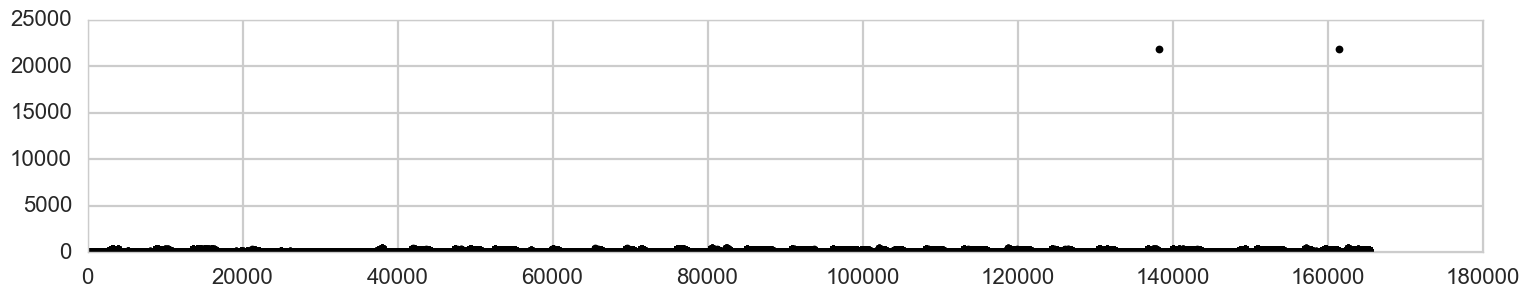

In [6]:
plt.figure(figsize=[18,3])
plt.plot(all_dat, 'k.')

In [7]:
all_utc, all_dat

all_utc = [x for x,y in zip(all_utc, all_dat) if y < 5000]
all_dat = [x for x in all_dat if x < 5000]

len(all_dat), len(all_utc)

(165355, 165355)

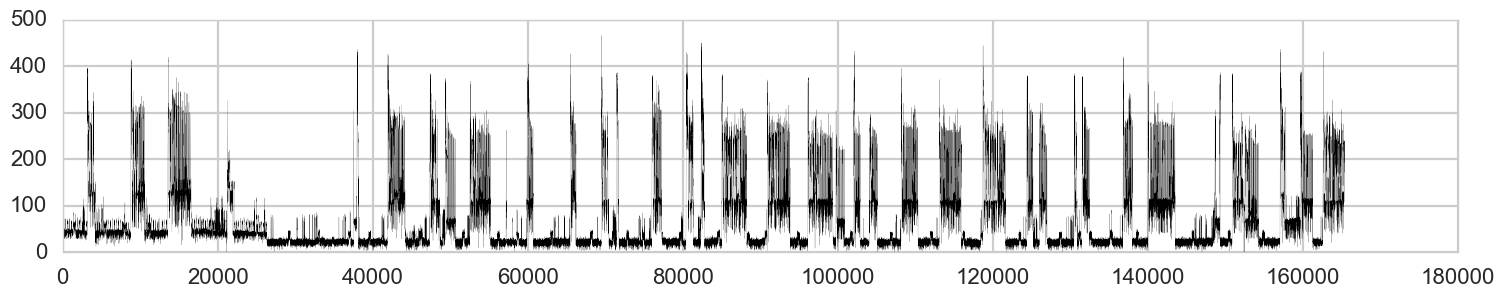

In [8]:
plt.figure(figsize=[18,3])
plt.plot(all_dat, 'k-', linewidth=.1)

In [9]:
raw_df = pd.DataFrame({'val': all_dat, 'tp': all_utc})
raw_df['tp'] = pd.to_datetime(raw_df['tp'])
raw_df.head()

,tp,val
0,2016-03-31 16:00:00,41.0
1,2016-03-31 16:00:15,43.0
2,2016-03-31 16:00:30,37.0
3,2016-03-31 16:00:45,43.0
4,2016-03-31 16:01:00,41.0


In [10]:
def read_manual_pt(fp):
    with open(fp) as fid:
        lines = [line.strip().split('\t')[1] for line in fid.readlines()]
    return lines

manual_pts = read_manual_pt('../results/4_1_manual_seg.txt')
manual_pts.extend( read_manual_pt('../results/4_2_manual_seg.txt') )

manual_pts_df = pd.DataFrame({'tp': manual_pts })
manual_pts_df['tp'] = pd.to_datetime(manual_pts_df['tp'])
manual_pts_df.head()

,tp
0,2016-04-01 05:07:00
1,2016-04-01 05:50:15
2,2016-04-01 06:19:00
3,2016-04-01 06:45:30
4,2016-04-01 07:15:30


In [11]:
import copy

def shift_left(list1, n):
    list2 = copy.copy(list1)
    if n > 0:
        list2 = list1[n:] + [np.nan for _ in range(n)]
    elif n< 0:
        list2 = [np.nan for _ in range(-n)] + list1[:n]
        
    return list2

shift_left(range(10), -2), shift_left(range(10), 2)

([nan, nan, 0, 1, 2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7, 8, 9, nan, nan])

In [12]:
n_list = []
n_list.extend(np.arange(-9, 10))

print n_list

val_dict = {}
val_dict = {str(n):shift_left(all_dat, n) for n in n_list}
val_dict['tp'] = all_utc

raw_df = pd.DataFrame(val_dict)
raw_df['tp'] = pd.to_datetime(raw_df['tp'])

raw_df.head()

[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,-1,-2,-3,-4,-5,-6,-7,-8,-9,0,1,2,3,4,5,6,7,8,9,tp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,43.0,37.0,43.0,41.0,41.0,43.0,47.0,46.0,41.0,2016-03-31 16:00:00
1,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,37.0,43.0,41.0,41.0,43.0,47.0,46.0,41.0,41.0,2016-03-31 16:00:15
2,43.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,43.0,41.0,41.0,43.0,47.0,46.0,41.0,41.0,41.0,2016-03-31 16:00:30
3,37.0,43.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,41.0,41.0,43.0,47.0,46.0,41.0,41.0,41.0,41.0,2016-03-31 16:00:45
4,43.0,37.0,43.0,41.0,NaN,NaN,NaN,NaN,NaN,41.0,41.0,43.0,47.0,46.0,41.0,41.0,41.0,41.0,40.0,2016-03-31 16:01:00


In [25]:
raw_df_train = raw_df[raw_df.tp <= manual_pts_df.tp.max()]
raw_df_train.shape, raw_df.shape, len(all_dat), manual_pts_df.shape

((10583, 20), (165355, 20), 165355, (41, 1))

In [27]:
raw_df_train_x_all = raw_df_train.drop('tp', axis=1).values
raw_df_train_y_all = raw_df_train['tp'].isin( manual_pts_df['tp'] ).values

raw_df_train_x_all.shape, raw_df_train_y_all.shape

((10583, 19), (10583,))

In [ ]:
def generate_training_data( dat_x, dat_y ):
    mask = np.logical_not( np.any(np.isnan()) )

In [15]:
mask = np.logical_not( np.any(np.isnan(raw_df_train_x_all), axis=1) )

raw_df_train_x_all = raw_df_train_x_all[mask]
raw_df_train_y_all = raw_df_train_y_all[mask]

In [16]:
idx_positive = np.where(raw_df_train_y_all)[0]
idx_negative = np.where(raw_df_train_y_all==False)[0]
print len(idx_positive), len(idx_negative)

idx_negative = np.random.choice(idx_negative, len(idx_positive))
print len(idx_positive), len(idx_negative)

idx_select = []
idx_select.extend(idx_positive)
idx_select.extend(idx_negative)
print len(idx_select)

print raw_df_train_x_all.shape, raw_df_train_y_all.shape

raw_df_train_x = raw_df_train_x_all[idx_select]
raw_df_train_y = raw_df_train_y_all[idx_select]

print raw_df_train_x.shape, raw_df_train_y.shape


41 10533
41 41
82
(10574, 19) (10574,)
(82, 19) (82,)


In [17]:
from sklearn import svm
import sklearn

In [18]:
C = 1
svc = svm.SVC(kernel='linear', C=C).fit(raw_df_train_x, raw_df_train_y)

In [23]:
raw_df_pred = svc.predict(raw_df_train_x)
print raw_df_pred[:41]
print raw_df_pred[41:]

[False  True  True  True  True  True  True  True False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [20]:
print sklearn.metrics.classification_report( raw_df_pred, raw_df_train_y )

             precision    recall  f1-score   support

      False       1.00      0.89      0.94        46
       True       0.88      1.00      0.94        36

avg / total       0.95      0.94      0.94        82

